Let's check this glorious repo from R in Python
Some explanation here https://youtu.be/10pvXLKw5dQ
This file is also in /analysis with details.

Blogs:
1) Basic explanation ARIMA https://www.analyticsvidhya.com/blog/2018/08/auto-arima-time-series-modeling-python-r/
3) Comprehensive example is you would like to see what is ARIMA:
 https://datafai.com/auto-arima-using-pyramid-arima-python-package/

Library:
1) https://pypi.org/project/pmdarima/
2) http://alkaline-ml.com/pmdarima/0.9.0/setup.html

In [1]:
import sys
import os
from tqdm import tqdm
import pmdarima as pm
from pmdarima.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
import pandas as pd
sys.path.insert(0, os.path.abspath('../../covid_forecast'))
from covid_forecast.utils.data_io import get_data, download_csv_from_link
from covid_forecast.utils.visualizations import plt_arima_forecast,plt_arima_forecast_outsample, render_pic_in_notebook


# where to save things
OUTPUT = '../outputs/arima'
os.makedirs(OUTPUT,exist_ok=True)

In case you need to refresh the data, you need a folder /data. From www.ecdc.europa.eu.

In [2]:
#download_csv_from_link()

# Load the data
Source www.ecdc.europa.eu

In [3]:
data = get_data()

In [4]:
# Quick look to the data. Source www.ecdc.europa.eu

In [5]:
data.head()

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2018
0,27/03/2020,27,3,2020,0,0,Afghanistan,AF,AFG,37172386.0
1,26/03/2020,26,3,2020,33,0,Afghanistan,AF,AFG,37172386.0
2,25/03/2020,25,3,2020,2,0,Afghanistan,AF,AFG,37172386.0
3,24/03/2020,24,3,2020,6,1,Afghanistan,AF,AFG,37172386.0
4,23/03/2020,23,3,2020,10,0,Afghanistan,AF,AFG,37172386.0


In [6]:
data.describe()

,day,month,year,cases,deaths,popData2018
count,7125.000000,7125.000000,7125.000000,7125.000000,7125.000000,7.118000e+03
mean,16.522386,2.228912,2019.990596,74.108772,3.321965,7.219029e+07
std,8.225466,1.267308,0.096521,554.117774,31.972887,2.155744e+08
min,1.000000,1.000000,2019.000000,-9.000000,0.000000,1.000000e+03
25%,10.000000,1.000000,2020.000000,0.000000,0.000000,4.403319e+06
50%,17.000000,2.000000,2020.000000,0.000000,0.000000,1.072767e+07
75%,23.000000,3.000000,2020.000000,5.000000,0.000000,5.163526e+07
max,31.000000,12.000000,2020.000000,16797.000000,795.000000,1.392730e+09


# Countries to work with

In [7]:
data.columns

Index(['dateRep', 'day', 'month', 'year', 'cases', 'deaths',
       'countriesAndTerritories', 'geoId', 'countryterritoryCode',
       'popData2018'],
      dtype='object')

In [8]:
# All countries
# country_list = data['Countries and territories'].unique()
country_list = ['China', 'Italy', 'Germany', 'India', 'Spain', 'United_Kingdom', 'United_States_of_America',
                     'Lithuania', 'Cyprus']
country_list

['China',
 'Italy',
 'Germany',
 'India',
 'Spain',
 'United_Kingdom',
 'United_States_of_America',
 'Lithuania',
 'Cyprus']

# Where eveything happends

In [31]:
data = get_data()
report_country = pd.DataFrame()
report = pd.DataFrame()
for country in tqdm(country_list):
    print('Working on: {}'.format(country))
    first_variable = pd.DataFrame()
    for variable in ['cases', 'deaths']:
        try:
            data_ = data[data['countriesAndTerritories'] == country].copy()
            data_ = data_.sort_values(by='dateRep')
            # Triming initial zeros
            remove_initia_zeros = np.trim_zeros(data_[variable]).__len__()
            # y = data_[variable][0:remove_initia_zeros]
            y = data_[variable][-remove_initia_zeros:]
            data_labels = data_['dateRep'][-remove_initia_zeros:]
            # taking the last 3. # Change it to any other amount
            lenght_for_forecast = 3
            # Fit your model
            model = pm.auto_arima(y, seasonal=False, suppress_warnings=True)
            # make your forecasts
            # predict N steps into the future
            forecasts, conf_int = model.predict(lenght_for_forecast, return_conf_int=True)
            # Adding labels for each new day
            data_labels = data_labels.to_list()
            for i in range(1,lenght_for_forecast+1):
                data_labels.append(data_labels[-1] + timedelta(1))
            forecasts, conf_int = model.predict(lenght_for_forecast, return_conf_int=True)
            # Visualize the forecasts (blue=train, green=forecasts)
            plt_arima_forecast_outsample(y, forecasts, conf_int=conf_int,
                       title=country,
                       y_label=variable,
                       x=data_labels,
                       save_here=OUTPUT + '/forecast_next_3days_{}_{}.png'.format(country, variable))
            # To save the data
            df_for_data = pd.DataFrame()
            df_for_data = pd.DataFrame(y.to_list()+forecasts.tolist(),
                columns=[variable])
            df_for_data['countriesAndTerritories'] = country
            df_for_data['dateRep'] = data_labels
            if first_variable.empty:
                first_variable = df_for_data
            else:
                first_variable = first_variable.merge(df_for_data, on=('dateRep', 'countriesAndTerritories'))
        except Exception as e: print(e)
    if report.empty:
        report = first_variable
    else:
        report = pd.concat([report, first_variable])
if report_country.empty:
    report_country = report
else:
    report_country = pd.concat([report_country, report])
# Creation of report
report_country.to_csv(OUTPUT+"/forecast_next_free_days.csv")

  0%|          | 0/9 [00:00<?, ?it/s]

Working on: China
can only concatenate str (not "datetime.timedelta") to str


 11%|█         | 1/9 [00:02<00:23,  2.99s/it]

can only concatenate str (not "datetime.timedelta") to str
Working on: Italy
can only concatenate str (not "datetime.timedelta") to str


 22%|██▏       | 2/9 [00:05<00:19,  2.74s/it]

can only concatenate str (not "datetime.timedelta") to str
Working on: Germany
can only concatenate str (not "datetime.timedelta") to str


 33%|███▎      | 3/9 [00:07<00:15,  2.51s/it]

can only concatenate str (not "datetime.timedelta") to str
Working on: India
can only concatenate str (not "datetime.timedelta") to str


 44%|████▍     | 4/9 [00:08<00:11,  2.26s/it]

can only concatenate str (not "datetime.timedelta") to str
Working on: Spain
can only concatenate str (not "datetime.timedelta") to str


 56%|█████▌    | 5/9 [00:11<00:08,  2.25s/it]

can only concatenate str (not "datetime.timedelta") to str
Working on: United_Kingdom
can only concatenate str (not "datetime.timedelta") to str


 67%|██████▋   | 6/9 [00:13<00:07,  2.39s/it]

can only concatenate str (not "datetime.timedelta") to str
Working on: United_States_of_America
can only concatenate str (not "datetime.timedelta") to str


 78%|███████▊  | 7/9 [00:15<00:04,  2.28s/it]

can only concatenate str (not "datetime.timedelta") to str
Working on: Lithuania
can only concatenate str (not "datetime.timedelta") to str


 89%|████████▉ | 8/9 [00:17<00:01,  2.00s/it]

can only concatenate str (not "datetime.timedelta") to str
Working on: Cyprus


/opt/anaconda3/envs/covid_forecast/lib/python3.7/site-packages/pmdarima/arima/auto.py:328: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
100%|██████████| 9/9 [00:17<00:00,  1.93s/it]

can only concatenate str (not "datetime.timedelta") to str
too many indices for array


In [32]:
data_labels

1621    27/03/2020
Name: dateRep, dtype: object

# Now let see some of the pics
## Spain

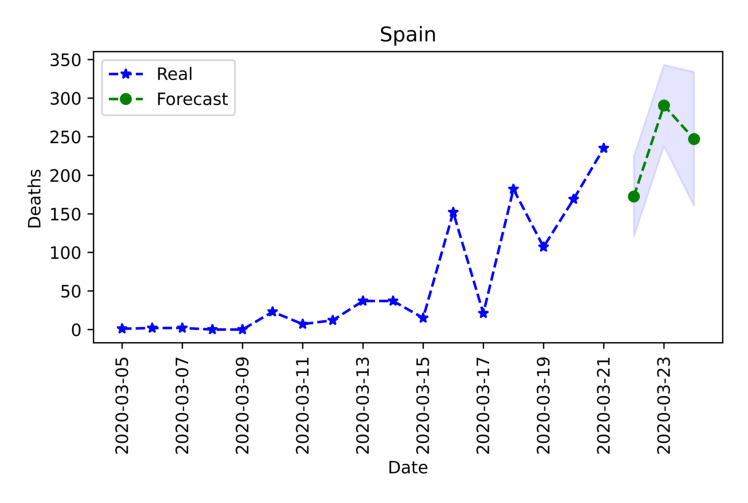

In [33]:
render_pic_in_notebook('../outputs/arima/forecast_next_3days_Spain_Deaths.png')

You can see the predictions at the top.

In [11]:
report_country[report_country['Countries and territories']=='Spain'].sort_values(by='DateRep',ascending = False).head()

KeyError: 'Countries and territories'

In [ ]:
render_pic_in_notebook('../outputs/arima/forecast_next_3days_Spain_Deaths.png')

## United Kingdom

In [ ]:
render_pic_in_notebook('../outputs/arima/forecast_next_3days_United_Kingdom_Deaths.png')
render_pic_in_notebook('../outputs/arima/forecast_next_3days_United_Kingdom_Cases.png')

## India

In [ ]:
render_pic_in_notebook('../outputs/arima/forecast_next_3days_India_Deaths.png')
render_pic_in_notebook('../outputs/arima/forecast_next_3days_India_Cases.png')

## United_States_of_America

In [ ]:
render_pic_in_notebook('../outputs/arima/forecast_next_3days_United_States_of_America_Deaths.png')
render_pic_in_notebook('../outputs/arima/forecast_next_3days_United_States_of_America_Cases.png')